# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [39]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [40]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [41]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [42]:
#your turn
df = df_transactions.pivot(index='customer_name', columns='offer_id', values='n')
df = df.fillna(0).sort_index()
df.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

A: There is a tension between minimizing within cluster SS and maximizing the distance between cluster centroids. SS arbitrarily converges to zero with increading k as eventually each datapoint will define its own cluster. Clearly this is not optimal. The best value of SS is one that strikes the best balance between these tensions and can be identified by looking at where the marginal benefit (of a decrease in SS) of an extra cluster is small relative to the previous. This is the intuition behind the elbow method.

In [43]:
# your turn
x_cols = df.values

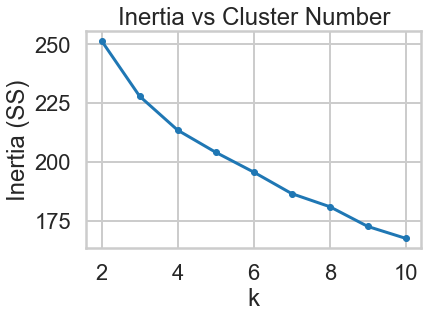

In [44]:

from sklearn.cluster import KMeans

inertia_list = []
labels_list = []
k_range = range(2,11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(x_cols)
    
    inertia_list.append(kmeans.inertia_)
    labels_list.append(kmeans.predict(x_cols))
    
_ = plt.plot(k_range, inertia_list, linestyle='-', marker='.')
_ = plt.xlabel('k')
_ = plt.ylabel('Inertia (SS)')
_ = plt.title('Inertia vs Cluster Number')

The curve is highly ambiguous and I will plot the difference in points as a bar chart (with sign reversed below) to illustrate this more clearly.

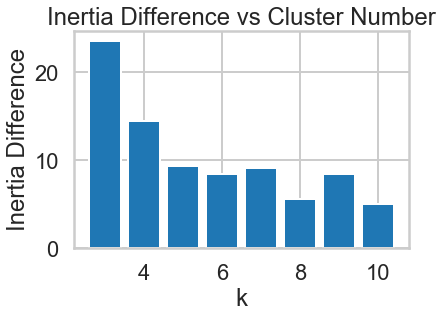

In [45]:
import numpy as np

inertia_arr = np.array(inertia_list)
inertia_slope = inertia_arr[:-1] - inertia_arr[1:]
idx = range(3,11)
_ = plt.bar(idx, inertia_slope)
_ = plt.xlabel('k')
_ = plt.ylabel('Inertia Difference')
_ = plt.title('Inertia Difference vs Cluster Number')

The first indication of the elbow kink comes at 4 and I will pick this as the 'best' k based on occam's razor. 

0    23
1    16
2    36
3    25
dtype: int64


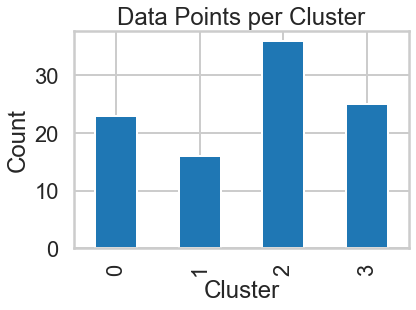

In [46]:
kmeans = KMeans(n_clusters=4, random_state=42)
labels_k4 = pd.Series(kmeans.fit_predict(x_cols))
print(labels_k4.value_counts().sort_index())
_ = labels_k4.value_counts().sort_index().plot(kind='bar', title='Data Points per Cluster')
_ = plt.xlabel('Cluster')
_ = plt.ylabel('Count')

A: The main difficulty with the elbow method is its relaince on visualization and the risk of ambiguity for certain datasets. The current example is a good case in point where the slope does not slow down significantly over the plotted range and we actually see an acceleration at k = 9. Even in more well behaved cases, there is likely to be some ambiguity as to where the elbow starts in the graph with viable cases within 1 to 2 spaces from eachother.    

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

Silhouette Plots

For k = 2 , Ave score is : 0.091749
For k = 3 , Ave score is : 0.121227
For k = 4 , Ave score is : 0.117898
For k = 5 , Ave score is : 0.111666
For k = 6 , Ave score is : 0.109193
For k = 7 , Ave score is : 0.119528
For k = 8 , Ave score is : 0.117722
For k = 9 , Ave score is : 0.134565
For k = 10 , Ave score is : 0.13508


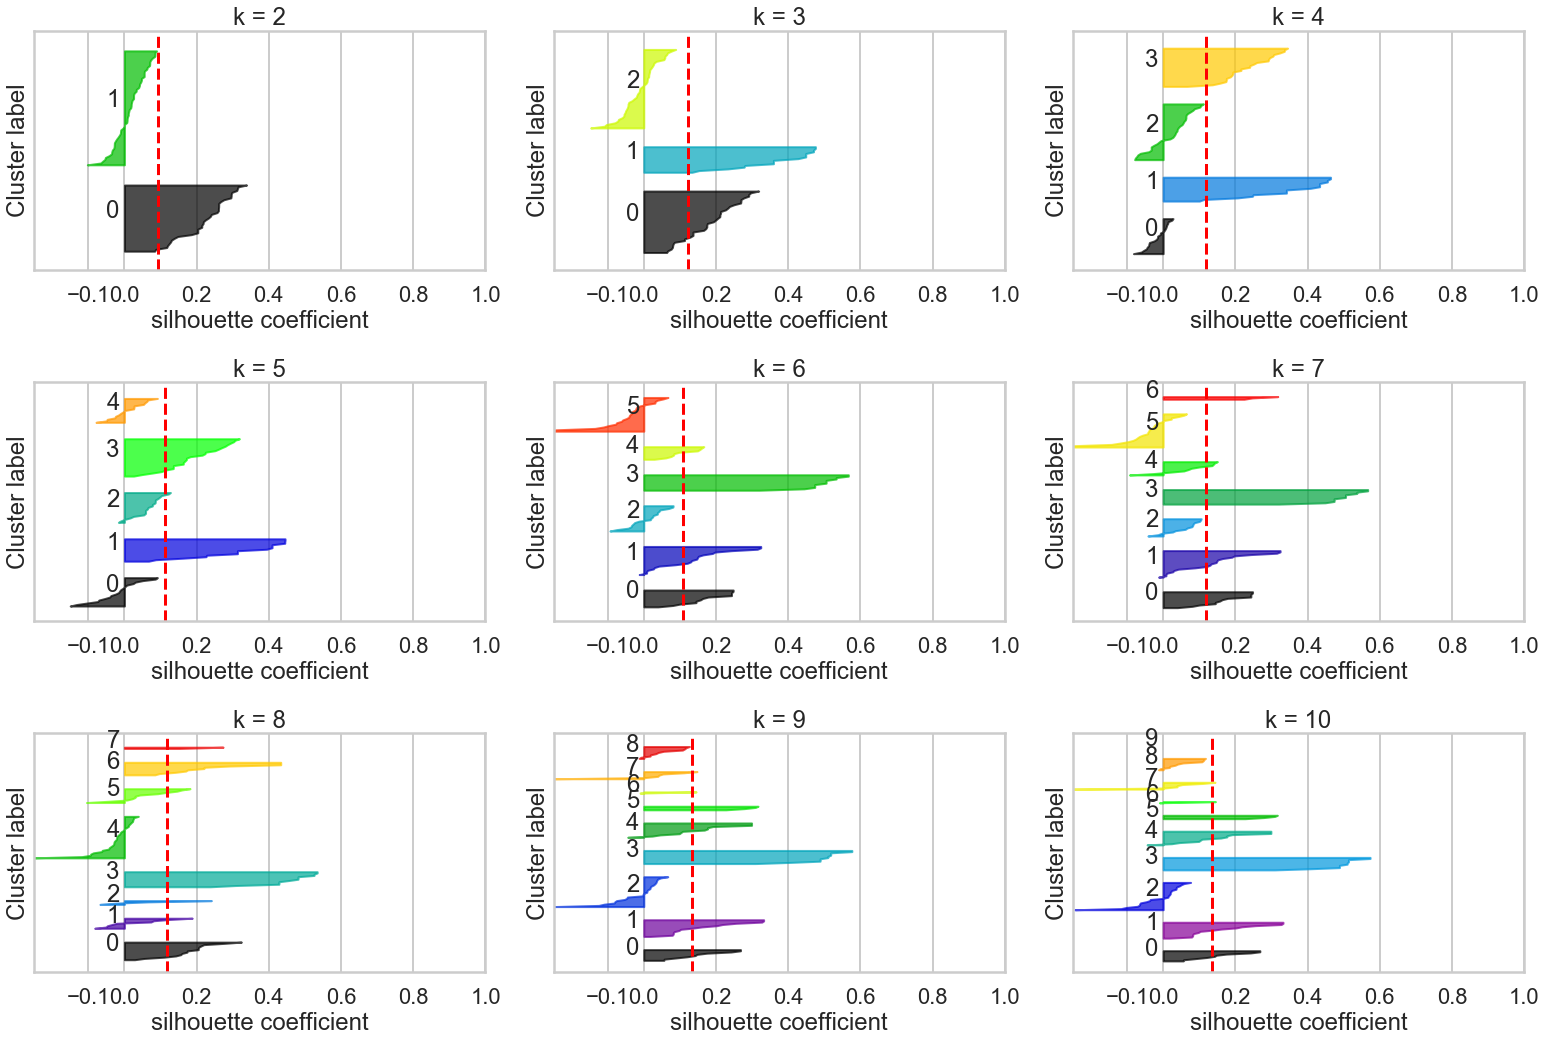

In [47]:
# Your turn.

#set more convenient notebook params for output scrolling
#from IPython.core.display import display, HTML
#display(HTML("<style>div.output_scroll { height: 100em; }</style>"))


from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

#set sklearn example variables to current variables
range_n_clusters = k_range
X= x_cols.copy()

#set grid and variables for plotting
plt.figure(figsize=(22,15))
graphs = len(range_n_clusters)
ncols = 3

if graphs % ncols ==0:
    nrows = graphs / ncols
else:
    nrows = graphs // ncols + 1

plot_number = 1

print("\033[1m" + "Silhouette Plots" + "\033[0m")    #print in bold
print("")


#Iterate through cluster number k
for n_clusters in range_n_clusters:
    # Create subplot
    ax1 = plt.subplot(nrows, ncols, plot_number)

    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.25, 1]
    ax1.set_xlim([-0.25, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
    print("For k =", n_clusters,',',
          "Ave score is :", round(silhouette_avg,6))

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("k = " + str(n_clusters))
    ax1.set_xlabel("silhouette coefficient")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    plot_number+=1

    plt.tight_layout()
    

A: Despite taking into account both intercluster and intracluster distances, the Silhouette score fails to get above 0.15 and suggests that no substantial structure was found. We also see negative score for various groups in every plot. Curiously, k=9 has the "best" score which is mirrored in the kink we saw for the elbow method. Nonetheless, 5 out of 9 clusters here have some incursion into negative values, the score is still extremely low and the complexity of 9 groups over only 100 samples makes this choice doubtful. While there is no obviously good choice, k= 3 to 6 might be reasonable and I see nothing to suggest chnaging the best guess as k=4. 

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

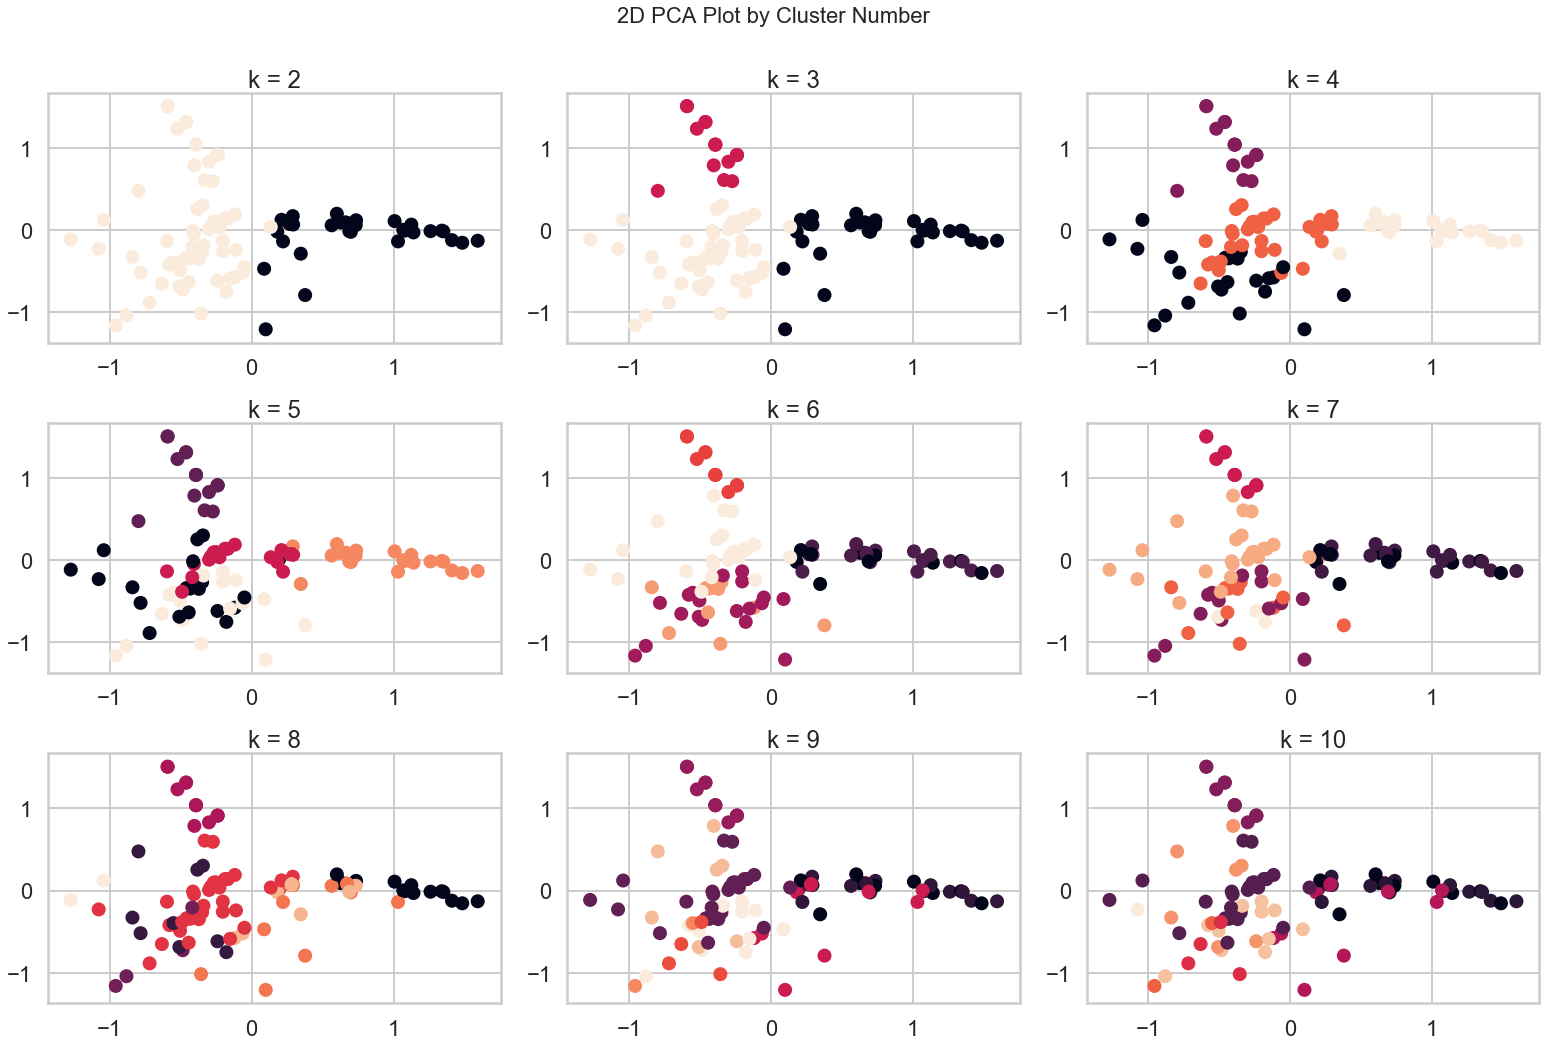

In [48]:
#your turn
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
transformed = pca.fit_transform(x_cols)
x = transformed[:,0]
y = transformed[:,1]

plt.figure(figsize=(22,15))
plt.suptitle('2D PCA Plot by Cluster Number', fontsize=22)

for idx, k in enumerate(k_range):
    ax1 = plt.subplot(nrows, ncols, idx+1)
    ax1.scatter(x, y, c=labels_list[idx])
    ax1.set_title("k = " + str(k))

plt.tight_layout()
plt.subplots_adjust(top=0.9)


A: K in the range 3 to 5 looks the most reasonable. Looking at the data without the labels, k=4 looks the most intuitive to me with a a large center bottom cluster and then three tails to the left, right and top. However, kmeans with k=4 picks out slighlt different clusters with more crossover between the bottom center and right tail than I might expect. K=2 gives a resonable decision boundary but k=3 is superior as it mostly keeps the integrity of this boundary while reflecting more variance in the data. K=5 also looks resonable but the small size of some of the samples is concerning. Everything above this looks like a mess. Thus, i would be comfortable in the k= 3 to 5 range based on the PCA plots. I'd be hesitant to give either method to much credit here as they were both somewhat ambiguous but the simplicity of the elbow method seems to have done a little better in encouraging a lower value of k.   

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

A: The code below merges customer with offer details in a single dataframe using k=4

In [49]:
#create map between customer name and cluster label
labels_k4.index = df.index
name_to_cluster = lambda x: labels_k4.loc[x]
#add cluster label column to transactions
df_transactions['cluster'] = df_transactions['customer_name'].apply(name_to_cluster)
#merge with offers to obtain offer particulars
df_merge = df_transactions.merge(df_offers, on='offer_id', how='left')
df_merge.head(1)

,customer_name,offer_id,n,cluster,campaign,varietal,min_qty,discount,origin,past_peak
0,Smith,2,1,1,January,Pinot Noir,72,17,France,False


In [50]:
#Varietals
varietal = pd.crosstab(df_merge['cluster'], df_merge['varietal'], normalize='index')
varietal = (varietal.round(2)*100)
varietal

varietal,Cabernet Sauvignon,Champagne,Chardonnay,Espumante,Malbec,Merlot,Pinot Grigio,Pinot Noir,Prosecco
cluster,,,,,,,,,
0,12.0,44.0,5.0,7.0,10.0,4.0,0.0,4.0,12.0
1,0.0,2.0,2.0,0.0,2.0,2.0,0.0,86.0,5.0
2,19.0,33.0,9.0,9.0,4.0,9.0,2.0,2.0,14.0
3,0.0,0.0,0.0,32.0,21.0,8.0,20.0,0.0,19.0


In [51]:
#Origin
origin = pd.crosstab(df_merge['cluster'], df_merge['origin'], normalize='index')
origin = origin.round(2)*100
origin

origin,Australia,California,Chile,France,Germany,Italy,New Zealand,Oregon,South Africa
cluster,,,,,,,,,
0,7.0,4.0,14.0,50.0,4.0,5.0,4.0,7.0,4.0
1,30.0,5.0,0.0,16.0,16.0,28.0,2.0,0.0,2.0
2,6.0,10.0,15.0,36.0,5.0,6.0,7.0,6.0,7.0
3,16.0,1.0,9.0,41.0,0.0,0.0,0.0,16.0,16.0


In [52]:
#Seasonality
seasons = {'summer': ['June','July','August'], 'Fall':['September', 'October', 'November'],
             'Winter':['December', 'January','February'], 'Spring':['March','April','May']}

def month_to_season(month):
    for k, v in seasons.items():
        if month in v:
            answer = k
        else:
            continue
    return answer

df_merge['season']= df_merge['campaign'].apply(month_to_season)
season = pd.crosstab(df_merge['cluster'], df_merge['season'], normalize='index')
season = season.round(2)*100
season

season,Fall,Spring,Winter,summer
cluster,,,,
0,12.0,25.0,29.0,34.0
1,60.0,5.0,16.0,19.0
2,17.0,32.0,31.0,20.0
3,20.0,43.0,21.0,16.0


In [53]:
#Past Peak 
past_peak = pd.crosstab(df_merge['cluster'], df_merge['past_peak'], normalize='index')
past_peak = past_peak.round(2)*100
past_peak

past_peak,False,True
cluster,,
0,81.0,19.0
1,100.0,0.0
2,74.0,26.0
3,84.0,16.0


In [54]:
#Bulk
qty = df_merge[['cluster', 'min_qty']].groupby('cluster').median()
qty

,min_qty
cluster,
0,72
1,72
2,72
3,6


In [55]:
#Discount
discount = df_merge[['cluster', 'discount']].groupby('cluster').median()
discount

,discount
cluster,
0,63
1,47
2,57
3,50


A: The most insightful of the variables is the varietal breakdown where we see 3 groups emerge from the 4. There are two groups have heavy champagne drinkers (44 to 33%), one group that almost only drinks pinot (86%) and another that strongly favors Espumante and drinks Prosecco instead of champagne. Interestingly, the pinot group makes 60% of their purchases over the fall and the Espumante group makes 43% of theirs over Spring. The other two groups are generally even across the seasons. The Espumante group buys in less quantity (median 6) than the others who are roughly the same around 72. The first champagne group appears the most price sensitive with a median discount of 63%.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

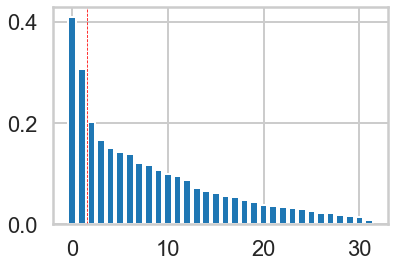

In [56]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(X)

# Do the rest on your own :)

features = range(pca.n_components_)
pca.explained_variance_
_ = plt.bar(features, pca.explained_variance_)
_ = plt.axvline(1.5, ls='--',lw=0.8, c='red')


A: Fortunately, the elbow point appears at D=2. 

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


Damp=  0.5 , number of clusters = 14
Damp=  0.97 , number of clusters = 11
Damp=  0.973 , number of clusters = 1


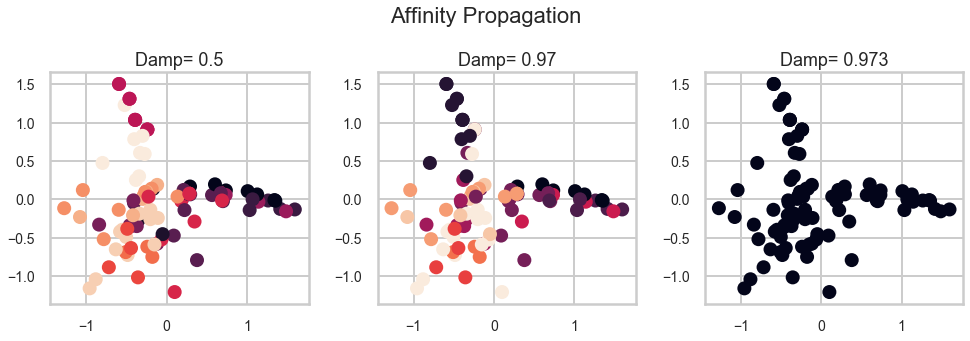

In [57]:
from sklearn.cluster import AffinityPropagation

plt.figure(figsize=(14,5))
plt.suptitle('Affinity Propagation', fontsize=22)
plot_number=1

damp_grid = [0.5, 0.97, 0.973]

for damp in damp_grid:
    clustering_ap = AffinityPropagation(damping=damp)
    labels_ap = clustering_ap.fit_predict(X)
    
    ax = plt.subplot(1, 3, plot_number)
    ax.scatter(x, y, c=labels_ap)
    ax.tick_params(labelsize=14)
    ax.set_title('Damp= ' + str(damp), fontsize=18)
    
    print('Damp= ', str(damp),',',
          'number of clusters =', max(labels_ap)+1)
    plot_number+=1

plt.tight_layout()
plt.subplots_adjust(top=0.8)

    


A: Albeit that I only checked across the damping paramter, AP did not appear to handle the dataset very well. The default paramter gave 14 groups and even as high as 0.97 yielded 11 groups. The effect of damping on cluster numbers became almost asymptotics from this point as 0.973 yielded one group. 

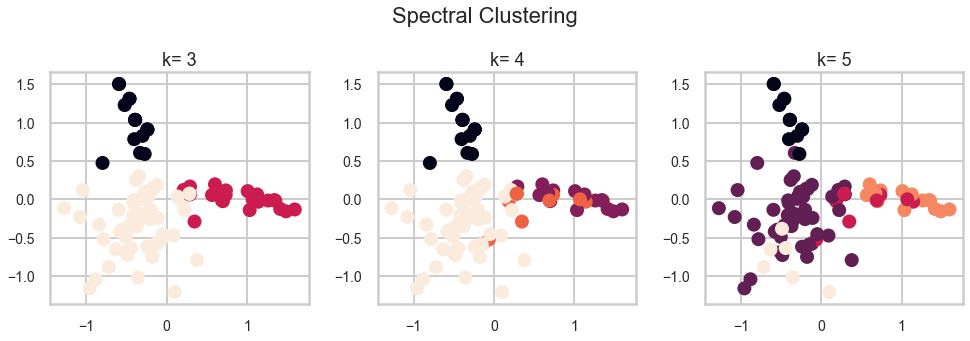

In [58]:
from sklearn.cluster import SpectralClustering

plt.figure(figsize=(14,5))
plt.suptitle('Spectral Clustering', fontsize=22)
plot_number=1

for n_clusters in range(3,6):
    clustering_sc = SpectralClustering(n_clusters=n_clusters,assign_labels='discretize',random_state=0)
    labels_sc = clustering_sc.fit_predict(X)
    
    ax = plt.subplot(1, 3, plot_number)
    ax.scatter(x, y, c=labels_sc)
    ax.tick_params(labelsize=14)
    ax.set_title('k= ' + str(n_clusters), fontsize=18)
    plot_number+=1

plt.tight_layout()
plt.subplots_adjust(top=0.8)

A: Spectral custering appeared to handle the dataset reasonably well. Its main difference with k-means is its propensity to keep the center left cluster intact with k=4 and 5.

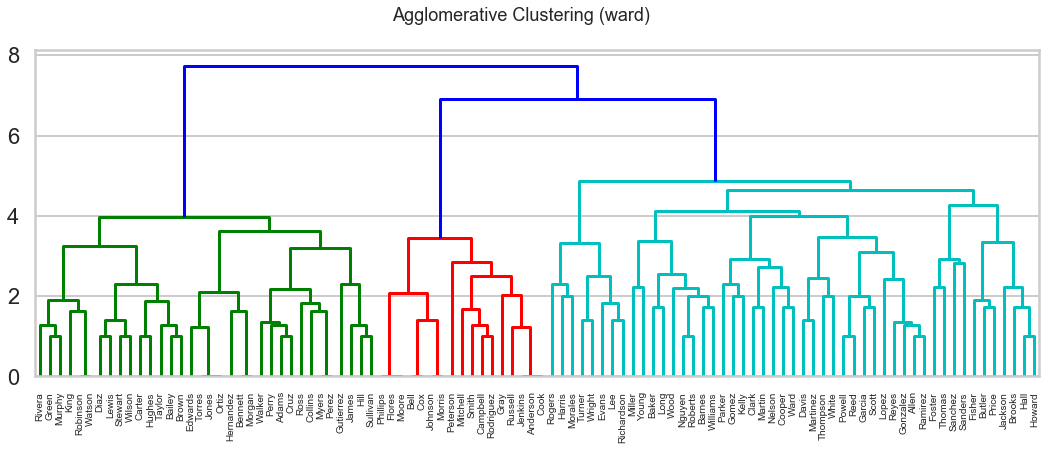

In [59]:
from scipy.cluster.hierarchy import linkage, dendrogram

method = 'ward'

plt.figure(figsize=(18,6))
plt.suptitle('Agglomerative Clustering (' + method + ')', fontsize=18)

mergings = linkage(X, method = method)
dendrogram(mergings, labels = df.index, leaf_rotation=90, leaf_font_size=10)

plt.grid(which='major', axis='x', linestyle='None')
plt.show()

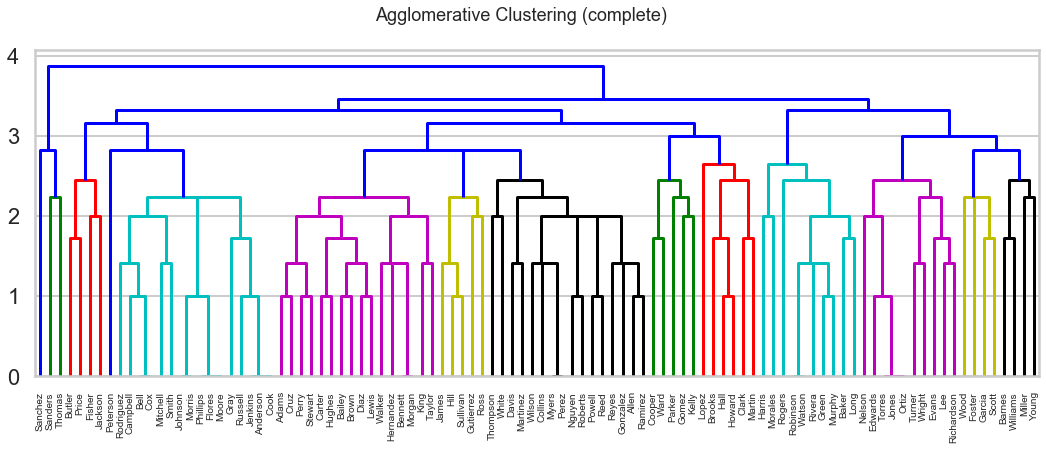

In [60]:
method = 'complete'

plt.figure(figsize=(18,6))
plt.suptitle('Agglomerative Clustering (' + method + ')', fontsize=18)

mergings = linkage(X, method = method)
dendrogram(mergings, labels = df.index, leaf_rotation=90, leaf_font_size=10)

plt.grid(which='major', axis='x', linestyle='None')
plt.show()

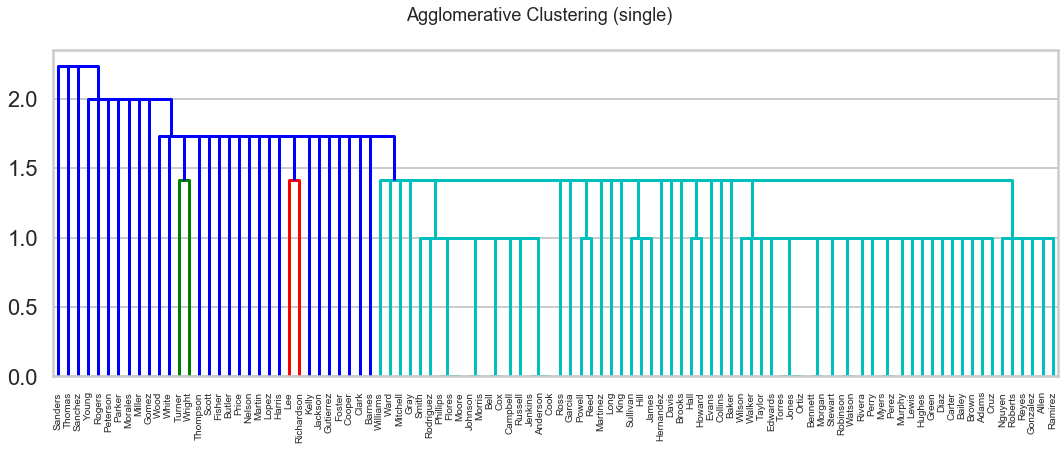

In [61]:
method = 'single'

plt.figure(figsize=(18,6))
plt.suptitle('Agglomerative Clustering (' + method + ')', fontsize=18)

mergings = linkage(X, method = method)
dendrogram(mergings, labels = df.index, leaf_rotation=90, leaf_font_size=10)

plt.grid(which='major', axis='x', linestyle='None')
plt.show()

A: AC is highly sensitive to the linking method for this dataset. Single linkage gave a very flat and uninformative structure. While complete linkage still gave a relatively flat structure, it was richer than single and hinted at 3 to 4 groups for higher level clustering. Ward linkage (sklearn's default) gave the clearest structure with 3 clear groups emerging. The largest of these groups indicated a potential split of 4.   

EPS=  0.5 , number of clusters = 0 , noise =  100.0 %
EPS=  1.2 , number of clusters = 4 , noise =  60.0 %
EPS=  3 , number of clusters = 1 , noise =  0.0 %


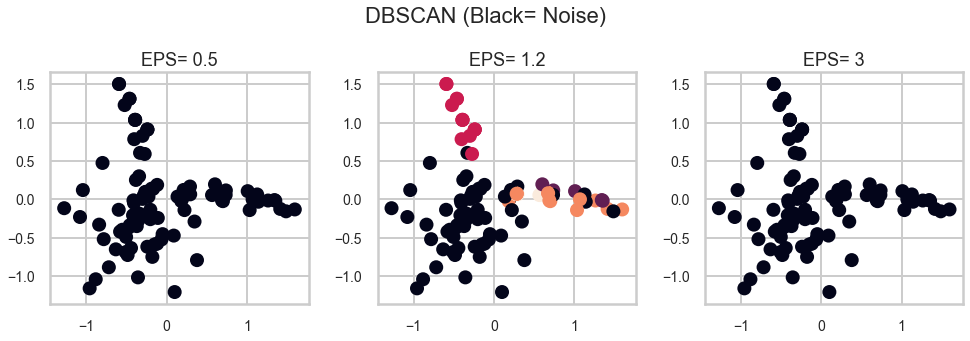

In [62]:
from sklearn.cluster import DBSCAN

plt.figure(figsize=(14,5))
plt.suptitle('DBSCAN (Black= Noise)', fontsize=22)
plot_number=1

eps_grid = [0.5, 1.2, 3]

for eps in eps_grid:
    clustering_db = DBSCAN(eps=eps)
    labels_db = clustering_db.fit_predict(X)
    
    noise = labels_db == -1
    noise_perc = round(sum(noise) / noise.shape[0],3)*100
    
    ax = plt.subplot(1, 3, plot_number)
    ax.scatter(x, y, c=labels_db)
    ax.tick_params(labelsize=14)
    ax.set_title('EPS= ' + str(eps), fontsize=18)
    
    print('EPS= ', str(eps),',',
           'number of clusters =', max(labels_db)+1,
            ', noise = ', noise_perc,'%' )
    plot_number+=1

plt.tight_layout()
plt.subplots_adjust(top=0.8)

A: DBSCAN performed poorly for this datset with a high noise ratio for most non-trivial number of clusters. 

A: In total, the most sensible results appeared to come from the algorithms with number size as paramters. Namely: kmeans, spectral and ward AC.  Without a clear metric to distinguish between them and relying on visualization, kmeans appeared to edge the others out. AP and DBSCAN were miserable. 